<a id="content"></a>
# QF605 Project: Fixed Income Securities
## `Part I`: Bootstrapping Swap Curves
### Team Members:
>Anirban CHAKRABORTY<br>
Boon Heng GOH<br>
Hanley Mahesh RUPAWALLA<br>
Kantapong ARUNADITYA<br>
Maria Vinitha VIJAYANAND<br>
Retwika HAZRA

- [Question 1](#Question1) <= Click
- [Question 2](#Question2)
- [Question 3](#Question3)

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from scipy.optimize import bisect, brentq
from scipy.interpolate import interp1d

import warnings
warnings.filterwarnings("ignore")

In [2]:
ois_meta = pd.read_excel('IR Data.xlsx', sheet_name = "OIS", header = 0).iloc[:,0:3]
irs_meta = pd.read_excel('IR Data.xlsx', sheet_name = "IRS", header = 0).iloc[:,0:3]

In [3]:
def TimetoYearfrac(x):
    if x[-1].lower() == "m":
        return float(x[:-1])/12
    elif x[-1].lower() == "y":
        return float(x[:-1])
    elif x[-1].lower() == "d":
        return float(x[:-1])/360

In [4]:
ois_meta['Tenor'] = ois_meta['Tenor'].apply(TimetoYearfrac)
irs_meta['Tenor'] = irs_meta['Tenor'].apply(TimetoYearfrac)

<a id="Question1"></a>
### 1. In the `IR Data.xlsm` spreadsheeet, OIS data is provided. Bootstrap the OIS discount factor $D_{o}$ (0, T) and plot the discount curve for T $\in$ [0, 30].

#### <u>Given
Day Count Convention = 30/360<br>
O/N Leg Frequency = Daily<br>
Fixed Leg Frequency = Annual

In [5]:
ois_input = ois_meta.iloc[:,[0,2]].copy()
ois_input.columns = ["Tenor", "OIS_Rate"]
ois_input["ON_Rate"] = np.nan
ois_input["ON_DF"] = np.nan

In [6]:
ois_input["ON_Rate"][0] = ((ois_input["Tenor"][0]*ois_input["OIS_Rate"][0] + 1)**(1/180) - 1)*360
ois_input["ON_Rate"][1] = (((ois_input["OIS_Rate"][1] + 1)/((1 + ois_input["ON_Rate"][0]/360)**180))**(1/180) - 1)*360

In [7]:
ois_input["ON_DF"][0] = 1/(1 + ois_input["Tenor"][0]*ois_input["OIS_Rate"][0])
ois_input["ON_DF"][1:] = 1/ (1 + ois_input["OIS_Rate"]*ois_input["Tenor"])[1:]

In [8]:
for n in range(2,len(ois_input)):
    Fixed_Leg = ois_input["OIS_Rate"][n]*ois_input["ON_DF"][1:n+1].sum()
    Float_Leg_1 =  ois_input["ON_DF"][1]*(((1 + ois_input["OIS_Rate"][0]/360)**180)*((1 + ois_input["OIS_Rate"][1]/360)**180) - 1)
    Float_Leg_2 =  np.nan_to_num(sum(ois_input["ON_DF"][i]*((1 + ois_input["ON_Rate"][i]/360)**360 - 1) for i in range(2,n)))
    def Overnight_Rate_Solver_Func(x, Fixed = Fixed_Leg, Float = Float_Leg_1 + Float_Leg_2):
        return Fixed - Float - ois_input["ON_DF"][n]*((1 + x/360)**360 - 1)
    ois_input["ON_Rate"][n] = brentq(Overnight_Rate_Solver_Func, 0, 1)
ois_input.to_csv('OIS_Rates_Raw.csv',sep=',')

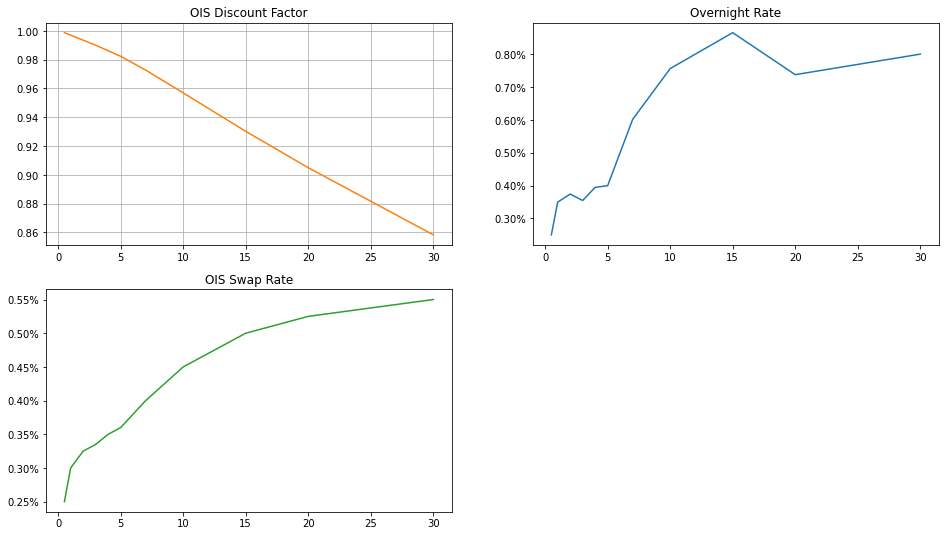

In [9]:
hf = plt.figure(figsize=(16, 9))

ha = hf.add_subplot(2,2,1)
ha.plot(ois_input["Tenor"], ois_input["ON_DF"], 'tab:orange')
ha.set_title('OIS Discount Factor')
ha.grid()

hb = hf.add_subplot(2,2,2)
hb.plot(ois_input["Tenor"], ois_input["ON_Rate"], 'tab:blue')
hb.set_title('Overnight Rate')
hb.yaxis.set_major_formatter(mtick.PercentFormatter(decimals = 2, xmax = 1.0))

hc = hf.add_subplot(2,2,3)
hc.plot(ois_input["Tenor"], ois_input["OIS_Rate"], 'tab:green')
hc.set_title('OIS Swap Rate')
hc.yaxis.set_major_formatter(mtick.PercentFormatter(decimals = 2, xmax = 1.0))

[Back to top](#content)

<a id="Question2"></a>
### 2. Using the IRS data provided, bootstrap the LIBOR discount factor D(0, T), and plot it for T $\in$ [0, 30].

- Assume that the swap market is collateralized in cash and overnight interest is paid on collateral posted.

`Bootstrapping the Libor Discount Factor`

#### <u>Given
Day Count Convention = 30/360<br>
Fixed Leg Frequency = Semi-Annual<br>
Float Leg Frequency = Semi-Annual

In [10]:
irs_input = irs_meta.iloc[:,[0,2]].copy()
irs_input.columns = ["Tenor", "IRS_Rate"]
irs_input["Libor_Rate"] = np.nan
irs_input["Libor_DF"] = np.nan
irs_input["Libor_Rate"][0] = irs_meta["Rate"][0]
irs_input["IRS_Rate"][0] = np.nan

In [11]:
irs_input_copy = pd.DataFrame(index = range(0, 60), columns = irs_input.columns)
irs_input_copy["Tenor"] = np.linspace(0,30,61)[1:]
irs_input = pd.concat([irs_input, irs_input_copy]).drop_duplicates(subset=['Tenor'], keep='first'
                                                                  ).sort_values(by = "Tenor").reset_index(drop=True)

In [12]:
BootStTable = pd.DataFrame(index = range(0, 60), columns = ["Tenor", "ON_Rate", "ON_DF", "IRS_Rate", "Libor_Rate", "Libor_DF"])
BootStTable["Tenor"] = np.linspace(0,30,61)[1:]
BootStTable = pd.merge(ois_input, BootStTable, how='outer', 
                       left_on=['Tenor','ON_DF', 'ON_Rate'], right_on = ['Tenor','ON_DF', 'ON_Rate']
                      ).drop_duplicates(subset=['Tenor'], keep='first').sort_values(by = "Tenor").reset_index(drop=True)
BootStTable["IRS_Rate"] = irs_input["IRS_Rate"]
BootStTable["Libor_Rate"] = irs_input["Libor_Rate"]
BootStTable["Libor_DF"] = irs_input["Libor_DF"]
BootStTable.head(10)

,Tenor,OIS_Rate,ON_Rate,ON_DF,IRS_Rate,Libor_Rate,Libor_DF
0,0.5,0.00250,0.002498,0.998752,NaN,0.025,NaN
1,1.0,0.00300,0.003493,0.997009,0.0280,NaN,NaN
2,1.5,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,0.00325,0.003741,0.993542,0.0300,NaN,NaN
4,2.5,NaN,NaN,NaN,NaN,NaN,NaN
5,3.0,0.00335,0.003545,0.99005,0.0315,NaN,NaN
6,3.5,NaN,NaN,NaN,NaN,NaN,NaN
7,4.0,0.00350,0.003946,0.986193,0.0325,NaN,NaN
8,4.5,NaN,NaN,NaN,NaN,NaN,NaN
9,5.0,0.00360,0.003996,0.982318,0.0330,NaN,NaN


In [13]:
#Interpolate the OIS Discount Factors
BootStTable["ON_DF"] = np.interp(BootStTable["Tenor"], ois_input["Tenor"], ois_input["ON_DF"])

In [14]:
# calculate L(0.5,1) and LIBOR_Discount(0,1)
BootStTable["Libor_DF"][0] = 1 / (1 + BootStTable["Tenor"][0]*BootStTable["Libor_Rate"][0])
BootStTable['Libor_Rate'][1] = (BootStTable["IRS_Rate"][1] * (BootStTable["ON_DF"][0]+BootStTable["ON_DF"][1]) - (BootStTable['Libor_Rate'][0] * BootStTable["ON_DF"][0]))/BootStTable["ON_DF"][1]
BootStTable['Libor_DF'][1] = (1 / (1 + 0.5 * BootStTable['Libor_Rate'][0])*(1 / (1 + 0.5* BootStTable['Libor_Rate'][1])))

In [15]:
i = 3
while i <= 60:
    h = i
    while np.isnan(BootStTable['IRS_Rate'][h]): # check if we have IRS rate
        h = h + 2
    Fixed_Leg = 0.5*BootStTable['IRS_Rate'][h]*BootStTable['ON_DF'][0:h+1].sum()
    Float_Leg_1 = sum(0.5*BootStTable['ON_DF'][k]*BootStTable['Libor_Rate'][k] for k in range(0,i-1))
    def Libor_Rate_Solver_Func(x):
        #Gradient for interpolation
        diff = BootStTable['Libor_DF'][i-2] - x
        #Last Available Discount Factor
        DFs = [BootStTable['Libor_DF'][i-2]]
        L_payoff_list = []
        for n in range(0,h-i+2):
            D = x + ((h-i+2-n-1)/(h-i+2))*diff # linear interpolation on LIBOR discount factor
            L_payoff = 0.5*(2*(DFs[-1]-D)/D)*BootStTable['ON_DF'][i-1+n] # unknown float payoff of each tenor
            DFs.append(D)
            L_payoff_list.append(L_payoff)
        Float_Leg_2 = sum(L_payoff_list)
        return Float_Leg_2 + Float_Leg_1 - Fixed_Leg
    D_last = brentq(Libor_Rate_Solver_Func, 0, 1)
    for n in range(0,h-i+2):
        BootStTable['Libor_DF'][i-1+n] = D_last + ((h-i+2-n-1)/(h-i+2))*(BootStTable['Libor_DF'][i-2] - D_last)
        BootStTable['Libor_Rate'][i-1+n] = (BootStTable['Libor_DF'][i-2+n]-BootStTable['Libor_DF'][i-1+n]
                                           )/(0.5*BootStTable['Libor_DF'][i-1+n])
    i = h+2 #move to next year 

In [16]:
BootStTable

,Tenor,OIS_Rate,ON_Rate,ON_DF,IRS_Rate,Libor_Rate,Libor_DF
0,0.5,0.00250,0.002498,0.998752,NaN,0.025000,0.987654
1,1.0,0.00300,0.003493,0.997009,0.0280,0.031005,0.972577
2,1.5,NaN,NaN,0.995275,NaN,0.031751,0.957378
3,2.0,0.00325,0.003741,0.993542,0.0300,0.032263,0.942179
4,2.5,NaN,NaN,0.991796,NaN,0.034218,0.92633
5,3.0,0.00335,0.003545,0.990050,0.0315,0.034814,0.910482
6,3.5,NaN,NaN,0.988122,NaN,0.035207,0.894731
7,4.0,0.00350,0.003946,0.986193,0.0325,0.035838,0.878981
8,4.5,NaN,NaN,0.984256,NaN,0.034713,0.863985
9,5.0,0.00360,0.003996,0.982318,0.0330,0.035326,0.84899


In [17]:
BootStTable["Libor_Rate"] = BootStTable["Libor_Rate"].astype(float)
BootStTable.to_csv('Rates_Raw.csv',sep=',', index=False)
BootStTable.head(10)

,Tenor,OIS_Rate,ON_Rate,ON_DF,IRS_Rate,Libor_Rate,Libor_DF
0,0.5,0.00250,0.002498,0.998752,NaN,0.025000,0.987654
1,1.0,0.00300,0.003493,0.997009,0.0280,0.031005,0.972577
2,1.5,NaN,NaN,0.995275,NaN,0.031751,0.957378
3,2.0,0.00325,0.003741,0.993542,0.0300,0.032263,0.942179
4,2.5,NaN,NaN,0.991796,NaN,0.034218,0.92633
5,3.0,0.00335,0.003545,0.990050,0.0315,0.034814,0.910482
6,3.5,NaN,NaN,0.988122,NaN,0.035207,0.894731
7,4.0,0.00350,0.003946,0.986193,0.0325,0.035838,0.878981
8,4.5,NaN,NaN,0.984256,NaN,0.034713,0.863985
9,5.0,0.00360,0.003996,0.982318,0.0330,0.035326,0.84899


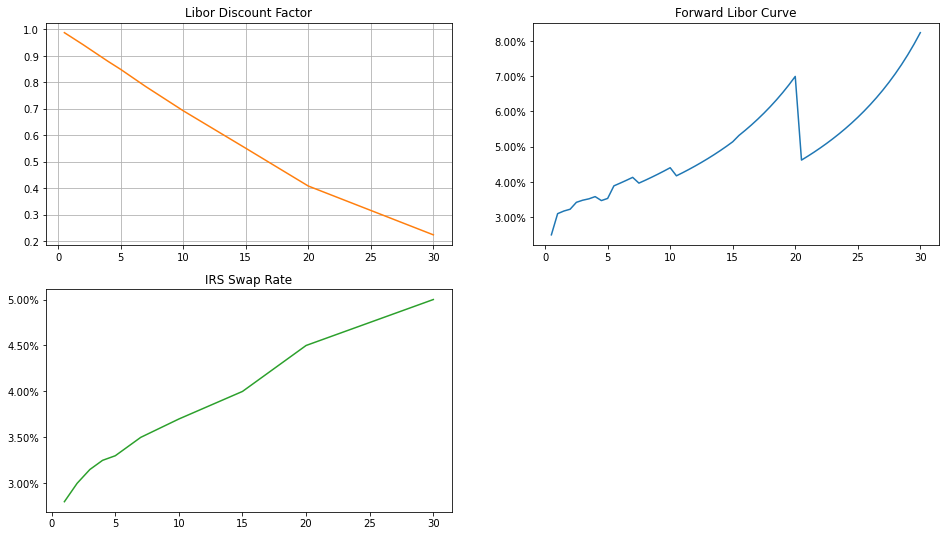

In [18]:
hf = plt.figure(figsize=(16, 9))

ha = hf.add_subplot(2,2,1)
ha.plot(BootStTable["Tenor"], BootStTable["Libor_DF"], 'tab:orange')
ha.set_title('Libor Discount Factor')
ha.grid()

hb = hf.add_subplot(2,2,2)
hb.plot(BootStTable["Tenor"], BootStTable["Libor_Rate"], 'tab:blue')
hb.set_title('Forward Libor Curve')
hb.yaxis.set_major_formatter(mtick.PercentFormatter(decimals = 2, xmax = 1.0))

hc = hf.add_subplot(2,2,3)
hc.plot(BootStTable[["Tenor", "IRS_Rate"]].dropna()["Tenor"], BootStTable[["Tenor", "IRS_Rate"]].dropna()["IRS_Rate"], 'tab:green')
hc.set_title('IRS Swap Rate')
hc.yaxis.set_major_formatter(mtick.PercentFormatter(decimals = 2, xmax = 1.0))

[Back to top](#content)

<a id="Question3"></a>
### 3. Calculate the following forward swap rates:

- 1y x 1y, 1y x 2y, 1y x 3y, 1y x 5y, 1y x 10y
- 5y x 1y, 5y x 2y, 5y x 3y, 5y x 5y, 5y x 10y
- 10y x 1y, 10y x 2y, 10y x 3y, 10y x 5y, 10y x 10y

`Calculating Forward Swap Rates`

In [19]:
starts = [1,5,10]
tenors = [1,2,3,4,5,10]

In [20]:
Swap_Rates = pd.DataFrame(index = range(0,len(starts)*len(tenors)), columns = ["Start", "Tenor", "Swap_Rate"])
i = 0
for st in starts:
    for ten in tenors:
        Swap_Rates.iloc[i, 0] = st
        Swap_Rates.iloc[i, 1] = ten
        i = i + 1

In [21]:
def Calc_SwapRate(start, tenor):
    st_idx = np.where(BootStTable["Tenor"]==start)[0].astype(np.int)[0]
    end_idx = np.where(BootStTable["Tenor"]==start + tenor)[0].astype(np.int)[0]
    Numerator = sum(0.5*BootStTable["ON_DF"][i]*BootStTable["Libor_Rate"][i] for i in range(st_idx + 1, end_idx+1))
    Denominator = sum(0.5*BootStTable["ON_DF"][i] for i in range(st_idx + 1, end_idx+1))
    return Numerator/Denominator

In [22]:
for i in range(0, len(Swap_Rates)):
    Swap_Rates["Swap_Rate"][i] = Calc_SwapRate(Swap_Rates["Start"][i], Swap_Rates["Tenor"][i])
#Formatting fixes
Swap_Rates.to_csv('Swap_Rates_Raw.csv',sep=',', index=False)
Swap_Rates["Swap_Rate"] = Swap_Rates[["Swap_Rate"]].applymap(lambda x: "{0:.2f}%".format(x*100))
Swap_Rates["Start"] = Swap_Rates["Start"].astype(str) + 'Y'
Swap_Rates["Tenor"] = Swap_Rates["Tenor"].astype(str) + 'Y'

In [23]:
Swap_Rates.pivot(index=["Start"], columns=["Tenor"],values="Swap_Rate").to_csv('Swap_Rates_Pivot.csv',sep=',')

[Back to top](#content)